# Reddit Depression dataset analysis that engage NLP and ML techniques
https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read dataset
df = pd.read_csv('depression_dataset_reddit_cleaned.csv')

print(df.head())
print(df.info())

                                                                                            clean_text  \
0  we understand that most people who reply immediately to an op with an invitation to talk private...   
1  welcome to r depression s check in post a place to take a moment and share what is going on and ...   
2  anyone else instead of sleeping more when depressed stay up all night to avoid the next day from...   
3  i ve kind of stuffed around a lot in my life delaying the inevitable of having to work a job and...   
4  sleep is my greatest and most comforting escape whenever i wake up these day the literal very fi...   

   is_depression  
0              1  
1              1  
2              1  
3              1  
4              1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depres

### Text distribution in term of length


count     7731.000000
mean       361.383003
std        695.268030
min          3.000000
25%         58.000000
50%        110.000000
75%        362.500000
max      19822.000000
Name: clean_text, dtype: float64


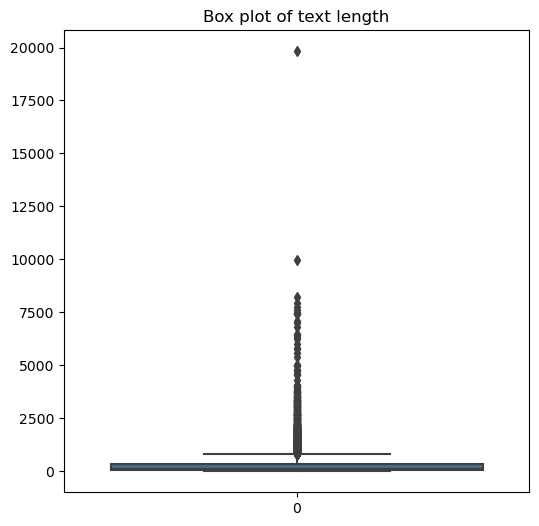

In [110]:
textLen = df['clean_text'].map(lambda x: len(x))
print(textLen.describe())

# quantile
Q1 = textLen.quantile(0.25)
Q3 = textLen.quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers = textLen[(textLen <= lower_bound) | (textLen >= 2000)]
df = df[~df.index.isin(outliers.index)].reset_index(drop=True)

# plot box plot
plt.figure(figsize=(6, 6))
sns.boxplot(textLen)
plt.title('Box plot of text length')
plt.show()

### Depression Label distribution


<Axes: xlabel='is_depression'>

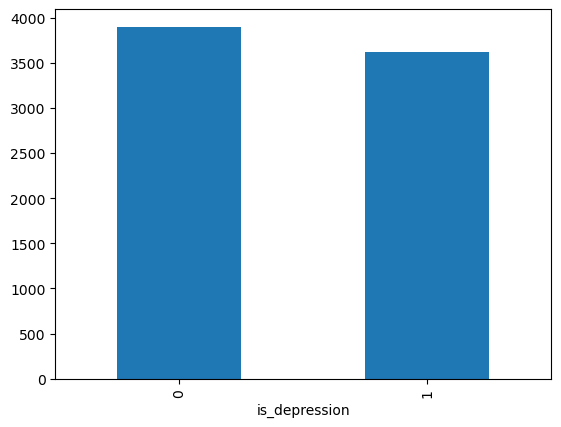

In [111]:
df['is_depression'].value_counts().plot(kind='bar')

### Distribution of text length by class

3619 3900


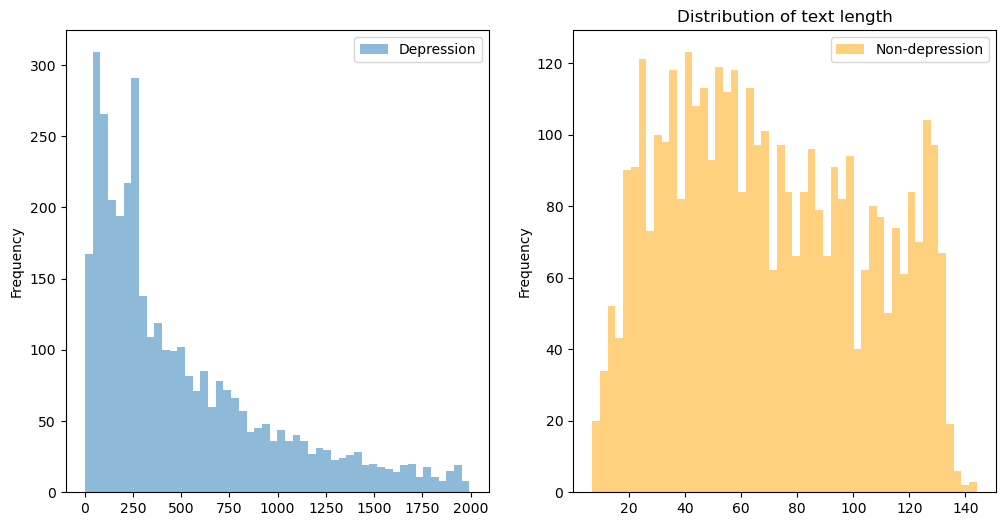

In [112]:
dep_df = df[df['is_depression'] == 1]
non_dep_df = df[df['is_depression'] == 0]

print(len(dep_df), len(non_dep_df))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st plot)

dep_df['clean_text'].map(lambda x: len(x)).plot(kind='hist', bins=50, alpha=0.5, label='Depression', legend=True)

plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd plot)
non_dep_df['clean_text'].map(lambda x: len(x)).plot(kind='hist', color='orange', bins=50, alpha=0.5, label='Non-depression', legend=True)
plt.title('Distribution of text length')
plt.show()

In [113]:
# print text with length < 100, adjust df so that all text are displayed
pd.set_option('display.max_colwidth', 100)

print(dep_df[dep_df['clean_text'].map(lambda x: len(x)) < 100].head(10))
print(non_dep_df[non_dep_df['clean_text'].map(lambda x: len(x)) < 100].head(10))

                                                                                          clean_text  \
23               it s so pointless for me to still be alive my life is worthless why am i still here   
33               i m starting to lose hope i feel like i m on auto pilot i m not living i m existing   
84                                      assuming you werent feeling better when you were taking them   
177                                    this isn t getting better and i don t want to be here anymore   
182                                                                          i can t take it anymore   
184  but telling them im not will just make them worry they got their own problem dont need mine too   
188                                                 i need friend i am so sad and lonely please help   
200          i feel completely exhausted my life isn t going anywhere and i ve got nobody to turn to   
204                                                             

## NLP Analysis

In [114]:
import re

contractions = pd.read_csv('contractions.csv')

# rename columns
contractions.columns = ['Contraction', 'Meaning']

# create a dictionary of contractions
contractions_dict = contractions.set_index('Contraction')['Meaning'].to_dict()

# create contraction regex pattern
contraction_patterns = r'\b(?:' + '|'.join([re.escape(c) for c in contractions_dict.keys()]) + r')\b'

def expand_contractions(text, pattern):
	def replace(match):
		return contractions_dict[match.group(0)]
	return re.sub(pattern, replace, text)

# expand contractions
df['clean_text'] = df['clean_text'].apply(lambda x: expand_contractions(x, contraction_patterns))

# remove special characters
df['clean_text'] = df['clean_text'].str.replace(r'[^a-zA-Z\s]', '')

# remove extra spaces
df['clean_text'] = df['clean_text'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespaces
df['clean_text'] = df['clean_text'].str.replace(r'^\s+|\s+?$', '')

print(df['clean_text'].head())


pd.set_option('display.max_colwidth', 100)
for s in df[df['clean_text'].map(lambda x: "http" in x)].loc[:, 'clean_text'].head(10):
	print(s)


0    anyone else instead of sleeping more when depressed stay up all night to avoid the next day from...
1    i have kind of stuffed around a lot in my life delaying the inevitable of having to work a job a...
2    sleep is my greatest and most comforting escape whenever i wake up these day the literal very fi...
3    i am year old turning soon in a few month i live in constant dread i have no passion no goal no ...
4    i live alone and despite me being prone to loneliness a i find myself to be emotionally needy i ...
Name: clean_text, dtype: object
he always seemed happy we always fucked around and had a good time we always talked about thing that bothered u but he never showed any sign that he wa upset or depressed i still sit around thinking why and can never draw any conclusion that would make sense i am slowly coming out of the mental ditch but i handled it by stuffing a much alcohol in me a possible i am coming out if that ditch but it still bum me out i completely stopped takin

- ### Stem and stopword

In [115]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stop_words.add('httpcom')
lemmatizer = WordNetLemmatizer()

# remove stop words and lemmatize
def preprocess_text(text):
	def getWordPOS(word):
		tag = nltk.pos_tag([word])[0][1][0].upper()
		tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
		return tag_dict.get(tag, 'n')

	word_tokens = word_tokenize(text)
	filtered_sentence = [lemmatizer.lemmatize(w, getWordPOS(w)) for w in word_tokens if w.lower() not in stop_words]
	return " ".join(filtered_sentence)

df['clean_text'] = df['clean_text'].map(preprocess_text)

# print text after preprocessing
print(df['clean_text'].head(10))


0    anyone else instead sleep depressed stay night avoid next day come sooner may social anxiety lif...
1    kind stuffed around lot life delay inevitable work job responsible adult long ever held job wa 9...
2    sleep great comfort escape whenever wake day literal first emotion feel misery remind problem ev...
3    year old turn soon month live constant dread passion goal special achievement life never relatio...
4    live alone despite prone loneliness find emotionally needy seem urge cut important people life g...
5    look sympathy simply state do try survive sit dark cry eye th birthday know last birthday shall ...
6    know communicate thought stay inside instead tell people like mind simply let try really try som...
7    mom sad hurt heart feel fall stomach stop tear start mom sad never anything never achieve anythi...
8    struggle depression long time first severe instance depersonalization scar badly even entirely s...
9    idk elaborate start suddenly cry real reason could

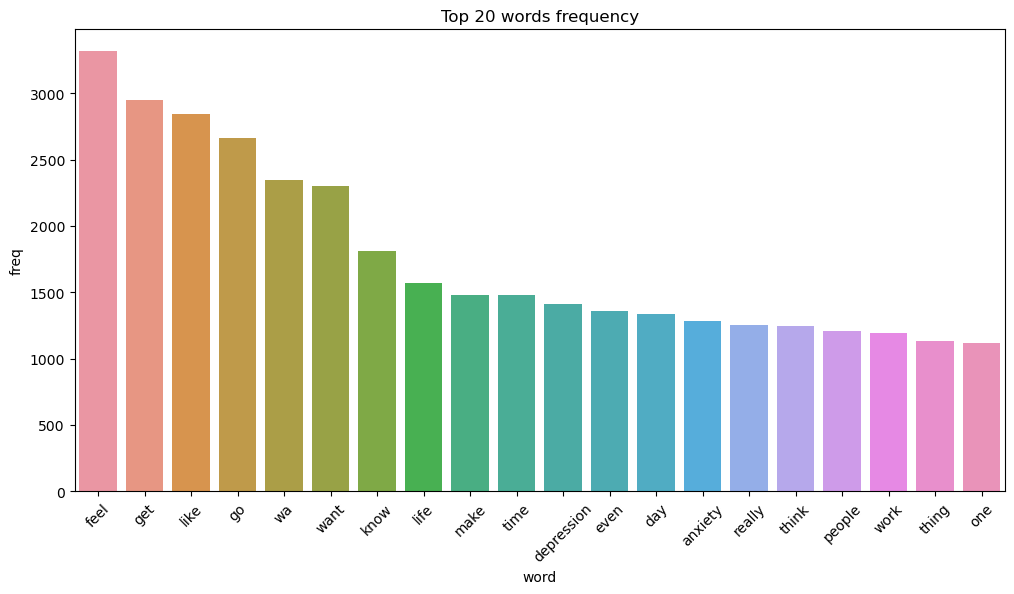

In [116]:
# word frequency
words = word_tokenize(' '.join(df['clean_text']))

from collections import Counter

word_freq = Counter(words)
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'freq'])
word_freq_df = word_freq_df.sort_values(by='freq', ascending=False)

#print(word_freq_df.head(20))
# plot word frequency
plt.figure(figsize=(12, 6))
sns.barplot(x='word', y='freq', data=word_freq_df.head(20))
plt.title('Top 20 words frequency')
plt.xticks(rotation=45)
plt.show()

### Depresion vs Non-Depression use of words

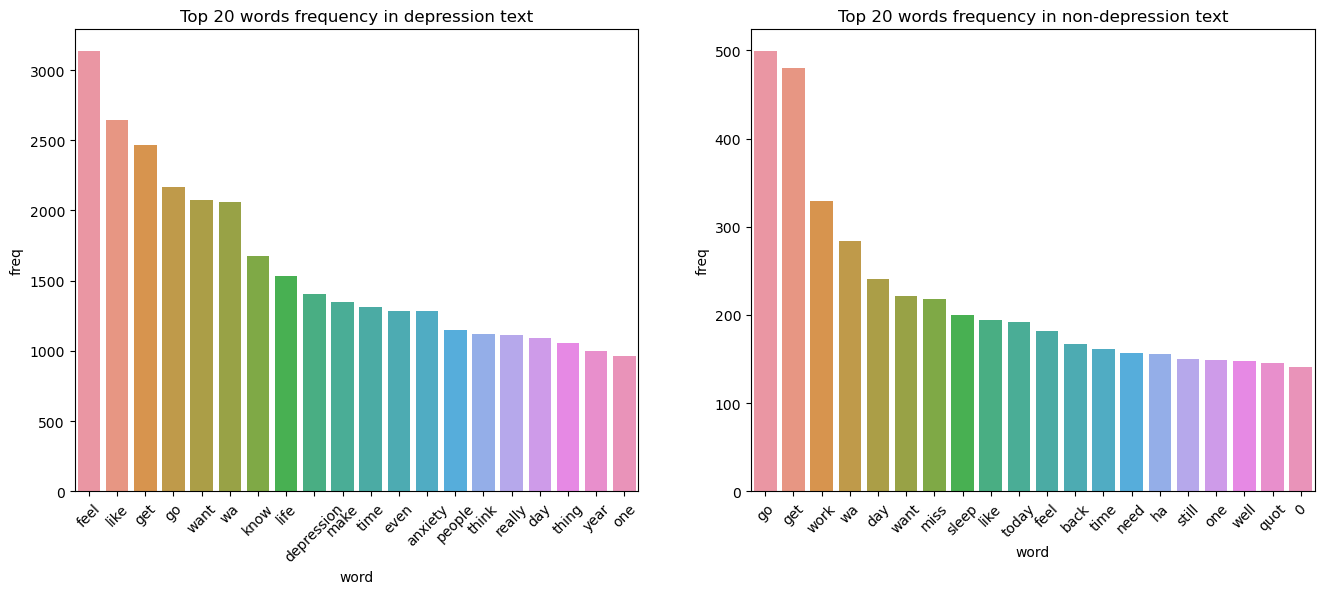

In [117]:

# get def_df and non_dep_df word frequency after preprocessing
dep_df = df[df['is_depression'] == 1]
non_dep_df = df[df['is_depression'] == 0]


# frequency of words in depression and non-depression text
dep_words = word_tokenize(' '.join(dep_df['clean_text']))
non_dep_words = word_tokenize(' '.join(non_dep_df['clean_text']))

dep_word_freq = Counter(dep_words)
non_dep_word_freq = Counter(non_dep_words)

dep_word_freq_df = pd.DataFrame(list(dep_word_freq.items()), columns=['word', 'freq'])
non_dep_word_freq_df = pd.DataFrame(list(non_dep_word_freq.items()), columns=['word', 'freq'])

dep_word_freq_df = dep_word_freq_df.sort_values(by='freq', ascending=False)
non_dep_word_freq_df = non_dep_word_freq_df.sort_values(by='freq', ascending=False)

# plot word frequency of depression and non-depression text in the same plot

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st plot)
sns.barplot(x='word', y='freq', data=dep_word_freq_df.head(20))
plt.title('Top 20 words frequency in depression text')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd plot)
sns.barplot(x='word', y='freq', data=non_dep_word_freq_df.head(20))
plt.title('Top 20 words frequency in non-depression text')
plt.xticks(rotation=45)

plt.show()



### Use of word wordcloud

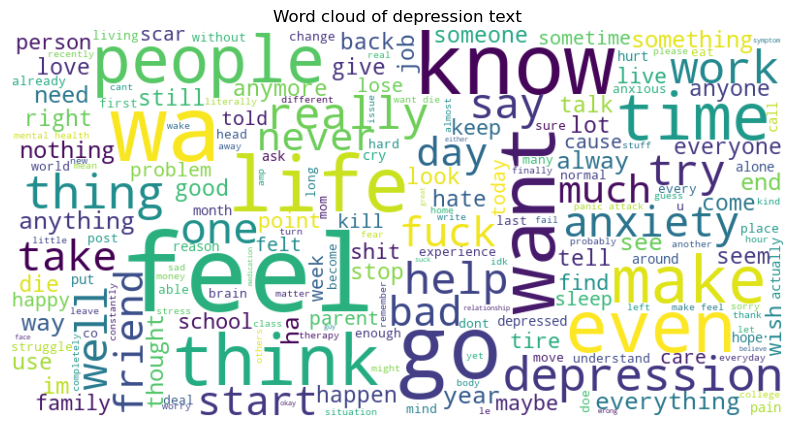

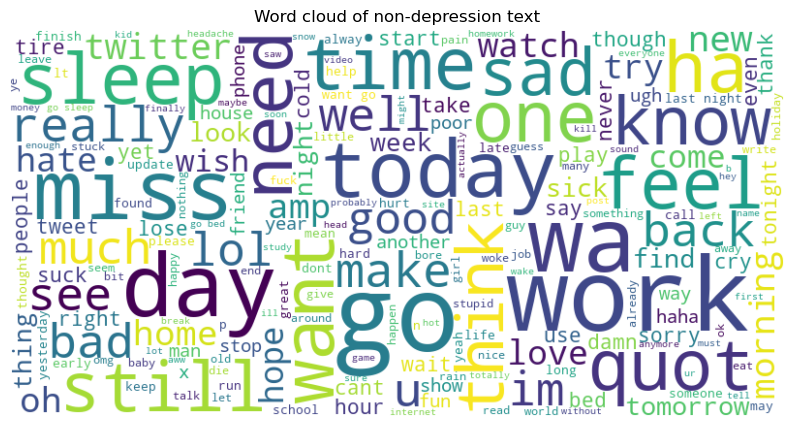

In [118]:
# word cloud of depression text
from wordcloud import WordCloud

wordCloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(' '.join(dep_df['clean_text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of depression text')
plt.show()


# word cloud of non-depression text
wordCloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(' '.join(non_dep_df['clean_text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of non-depression text')
plt.show()


### nGrams


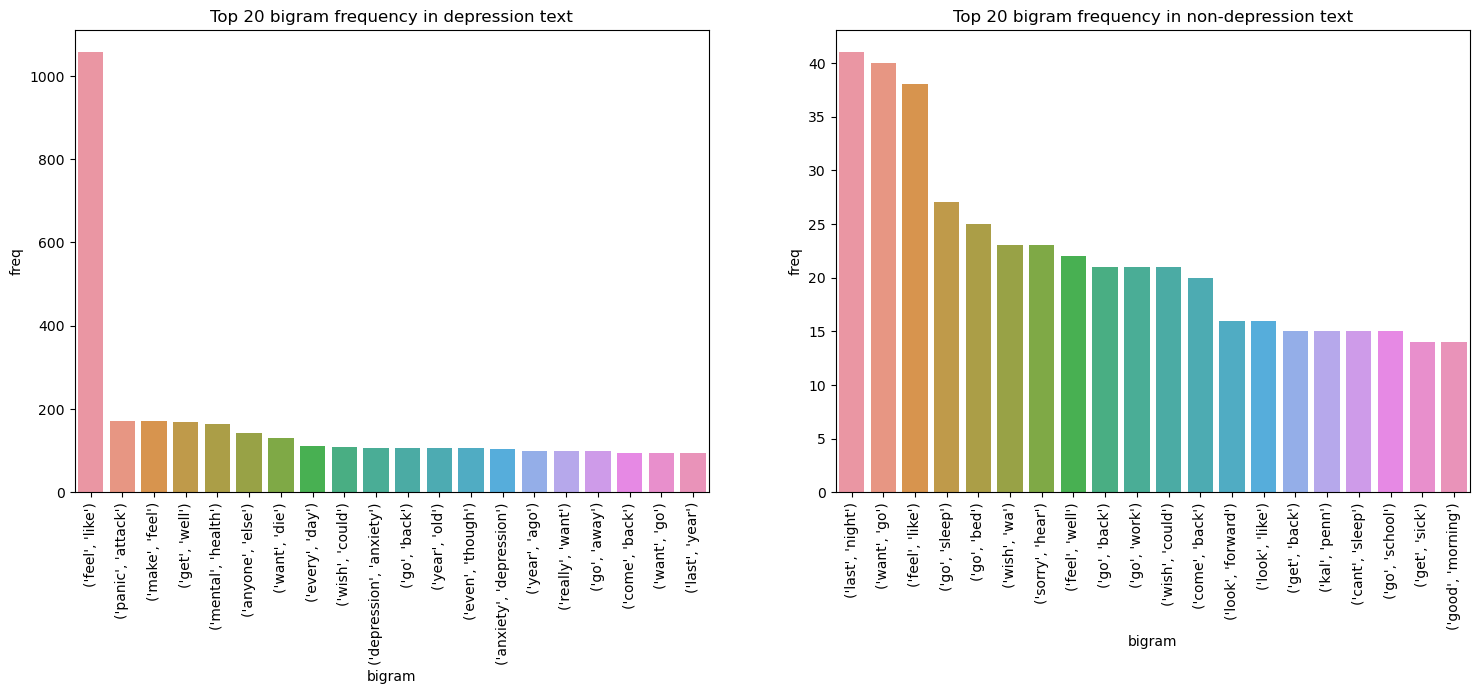

In [119]:
from nltk import ngrams

# get bigrams for depression
bigrams = ngrams(words, 2)
bigram_freq = Counter(bigrams)
bigram_freq_df = pd.DataFrame(list(bigram_freq.items()), columns=['bigram', 'freq'])

bigram_freq_df = bigram_freq_df.sort_values(by='freq', ascending=False)

# plot bigram frequency
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st plot)
sns.barplot(x='bigram', y='freq', data=bigram_freq_df.head(20))
plt.title('Top 20 bigram frequency in depression text')
plt.xticks(rotation=90)

# get bigrams for non-depression 
non_dep_bigrams = ngrams(non_dep_words, 2)
non_dep_bigram_freq = Counter(non_dep_bigrams)
non_dep_bigram_freq_df = pd.DataFrame(list(non_dep_bigram_freq.items()), columns=['bigram', 'freq'])

non_dep_bigram_freq_df = non_dep_bigram_freq_df.sort_values(by='freq', ascending=False)

# plot bigram frequency
plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd plot)
sns.barplot(x='bigram', y='freq', data=non_dep_bigram_freq_df.head(20))
plt.title('Top 20 bigram frequency in non-depression text')
plt.xticks(rotation=90)
plt.show()



## Precitive models
- ### TFIDF with some ML model


In [124]:
# preprocess text for modeling using tfidf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# fit and transform depression text
tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# create a DataFrame
tfidf_df = pd.DataFrame(tfidf.toarray())
Y = df['is_depression']

# get train, test split
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, Y, test_size=0.2, random_state=42)


In [125]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)
y_pred = logistic_model.predict(x_test)

print('Logistic Regression')
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))


Logistic Regression
Accuracy:  0.9547872340425532
Confusion matrix: 
 [[752  18]
 [ 50 684]]
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       770
           1       0.97      0.93      0.95       734

    accuracy                           0.95      1504
   macro avg       0.96      0.95      0.95      1504
weighted avg       0.96      0.95      0.95      1504



In [126]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

print('Random Forest')
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))


Random Forest
Accuracy:  0.9634308510638298
Confusion matrix: 
 [[766   4]
 [ 51 683]]
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       770
           1       0.99      0.93      0.96       734

    accuracy                           0.96      1504
   macro avg       0.97      0.96      0.96      1504
weighted avg       0.97      0.96      0.96      1504



In [127]:
# xgb Classifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

print('XGB Classifier')
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

XGB Classifier
Accuracy:  0.9634308510638298
Confusion matrix: 
 [[762   8]
 [ 47 687]]
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       770
           1       0.99      0.94      0.96       734

    accuracy                           0.96      1504
   macro avg       0.97      0.96      0.96      1504
weighted avg       0.96      0.96      0.96      1504



## Conclusion

- There are a bunch of link that need to be clean
- There are also contractions that does not have apostrophe. "i'm" -> "i m" also need cleanning.
- Depresion text varies more in length(up to thousand of letter) and follow Inverse Distribution.
- Non-Depression text is more concise in length with the longest being ~140 letter. and almost a uniform distribution.
- TFIDF and various ML model give high accuracy(97+ %)